In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alerce.core import Alerce

alerce = Alerce()
import requests

In [2]:
object_id = "ZTF25abcwzci"

In [3]:
# fink https://fink-broker.readthedocs.io/en/latest/services/search/getting_started/#quick-start-api
r = requests.post(
    "https://api.fink-portal.org/api/v1/objects",
    json={"objectId": object_id, "output-format": "json"},
)
pdf_fink = pd.read_json(io.BytesIO(r.content))
# rename TOM MOP OPM
namedic = {1: "ZTF_g", 2: "ZTF_r", 3: "ZTF_i"}
pdf_fink["filter"] = pdf_fink["i:fid"].map(namedic)
new_pdf_fink = pdf_fink[["i:jd", "filter", "i:magpsf", "i:sigmapsf", "d:mulens"]].copy()
new_pdf_fink = new_pdf_fink.rename(
    columns={"i:jd": "time", "i:magpsf": "magnitude", "i:sigmapsf": "error"}
)
# new_pdf.to_csv("{}.csv".format(pdf["i:objectId"][0]), index=False)

In [4]:
# ALeRCE https://alerce.readthedocs.io/en/latest/tutorials/ztf_api.html#query-lightcurve
alerce = Alerce()
lightcurve = alerce.query_lightcurve(object_id, format="json")
pdf_alerce = pd.DataFrame.from_dict(lightcurve["detections"])
probabilities = alerce.query_probabilities(object_id)
prob_pd = pd.DataFrame.from_dict(probabilities)
# rename TOM MOP OPM
namedic = {1: "ZTF_g", 2: "ZTF_r", 3: "ZTF_i"}
pdf_alerce["filter"] = pdf_alerce["fid"].map(namedic)
new_pdf_alerce = pdf_alerce[["mjd", "filter", "magpsf", "sigmapsf"]].copy()
# convert mjd to jd
new_pdf_alerce["mjd"] = new_pdf_alerce["mjd"] + 2400000.5
new_pdf_alerce = new_pdf_alerce.rename(
    columns={"mjd": "time", "magpsf": "magnitude", "sigmapsf": "error"}
)

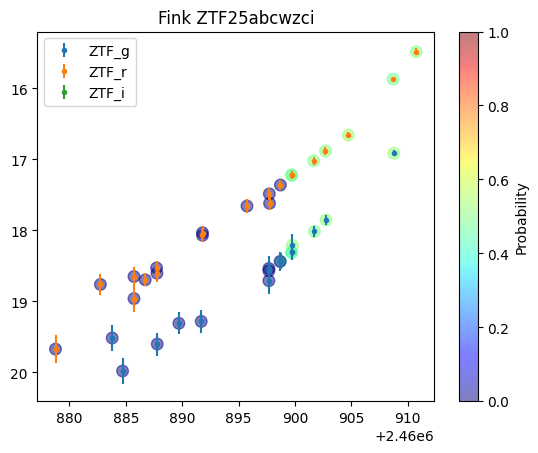

In [5]:
plt.gca().invert_yaxis()
plt.title("Fink {}".format(object_id))
for fid in range(1, 4):
    mask_filt = new_pdf_fink["filter"] == namedic[fid]
    plt.errorbar(
        new_pdf_fink["time"][mask_filt].array,
        new_pdf_fink["magnitude"][mask_filt].array,
        yerr=new_pdf_fink["error"][mask_filt].array,
        fmt=".",
        label=namedic[fid],
    )
    plt.scatter(
        new_pdf_fink["time"][mask_filt].array,
        new_pdf_fink["magnitude"][mask_filt].array,
        c=new_pdf_fink["d:mulens"][mask_filt].array,
        s=70,
        cmap="jet",
        zorder=0,
        alpha=0.5,
        vmin=0,
        vmax=1,
    )
cb = plt.colorbar()
cb.set_label("Probability")

plt.legend()

In [6]:
stochastic_bhrf_rank = prob_pd.loc[
    prob_pd["classifier_name"] == "lc_classifier_BHRF_forced_phot_stochastic"
]

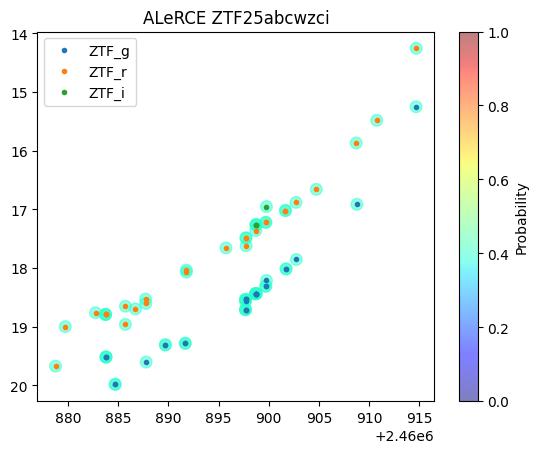

In [7]:
plt.gca().invert_yaxis()
plt.title("ALeRCE {}".format(object_id))
probability_last = stochastic_bhrf_rank[
    stochastic_bhrf_rank["class_name"] == "Microlensing"
]["probability"].iloc[0] * np.ones(len(new_pdf_alerce["time"]))
for fid in range(1, 4):
    mask_filt = new_pdf_alerce["filter"] == namedic[fid]
    plt.errorbar(
        new_pdf_alerce["time"][mask_filt].array,
        new_pdf_alerce["magnitude"][mask_filt].array,
        fmt=".",
        label=namedic[fid],
    )
    plt.scatter(
        new_pdf_alerce["time"][mask_filt].array,
        new_pdf_alerce["magnitude"][mask_filt].array,
        c=probability_last[mask_filt],
        s=70,
        cmap="jet",
        zorder=0,
        alpha=0.5,
        vmin=0,
        vmax=1,
    )
cb = plt.colorbar()
cb.set_label("Probability")
plt.legend()

In [8]:
# %config InlineBackend.figure_formats = ['svg']
import numpy as np
from iminuit import Minuit, cost
from matplotlib import pyplot as plt
from numba_stats import bernstein, norm, t, truncexpon

In [19]:
def pspl_blend(x, log10u0, log10te, t0, fs, fb):
    u0 = 10**log10u0
    te = 10**log10te
    usqr = u0**2 + (x - t0) ** 2 / te**2
    return fs * (usqr + 2) / (usqr * (usqr + 4.0)) ** 0.5 + fb


mask_filt = new_pdf_alerce["filter"] == namedic[1]
#flux rescaled to max 1
flux = 10.0 ** (-0.4 * new_pdf_alerce["magnitude"][mask_filt].array) / np.max(
    10.0 ** (-0.4 * new_pdf_alerce["magnitude"][mask_filt].array)
)
err_flux = np.abs(new_pdf_alerce["error"][mask_filt].array * flux * np.log(10) / 2.5)
guess = (
    np.log10(1),
    np.log10(30.0),
    new_pdf_alerce["time"][mask_filt].array[
        np.argmax(new_pdf_alerce["time"][mask_filt].array - 2450000)
    ]
    - 2450000,
    np.median(flux),
    np.min(flux),
)
print(guess)
c = cost.LeastSquares(
    new_pdf_alerce["time"][mask_filt].array - 2450000, flux, err_flux, pspl_blend
)
m = Minuit(c, *guess)

m.migrad()

(0.0, 1.4771212547196624, 10914.670486100018, 0.04856699130137, 0.0128310205341177)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.4 (χ²/ndof = 0.6)       │              Nfcn = 831              │
│ EDM = 0.0355 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ log10u0 │  -0.988   │   0.020   │            │            │         │         │       │
│ 1 │ log10te │   1.245   │   0.023   │            │            │         │         │       │
│ 2 │ t0      │ 10.9158e3 │ 0.0005e3  │            │            │         │         │       │
│ 3 │ fs      │   0.138   │   0.019   │            │            │         │         │       │
│ 4 │ fb      │  -0.135   │   0.019   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────────────────────────────────────────┐
│         │  log10u0  log10te       t0       fs       fb │
├─────────┼──────────────────────────────────────────────┤
│ log10u0 │ 0.000405   0.1e-3  -3.6e-3  -0.1e-3   0.1e-3 │
│ log10te │   0.1e-3 0.000528  -8.9e-3  -0.4e-3   0.4e-3 │
│      t0 │  -3.6e-3  -8.9e-3    0.228   9.1e-3  -9.1e-3 │
│      fs │  -0.1e-3  -0.4e-3   9.1e-3 0.000376  -0.4e-3 │
│      fb │   0.1e-3   0.4e-3  -9.1e-3  -0.4e-3 0.000378 │
└─────────┴──────────────────────────────────────────────┘

In [20]:
10.0 ** m.values["log10te"], 10.0 ** m.values["log10u0"]

(17.56542882657488, 0.10290575509275152)